# Retention Insert Scores Fallback
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [ ]:
import boto3
import getpass
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import awswrangler as wr
import warnings

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [3]:
lkupclientid = 8
dbname = 'stlrnll'

cursor = CNXN.cursor()

storedProc = (
    f"""Exec {dbname}.[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7982 entries, 0 to 7981
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            7982 non-null   int64  
 1   dimCustomerMasterId     7982 non-null   int64  
 2   customerNumber          7982 non-null   object 
 3   year                    7982 non-null   int64  
 4   productGrouping         7982 non-null   object 
 5   totalSpent              7982 non-null   float64
 6   recentDate              7982 non-null   object 
 7   attendancePercent       7982 non-null   float64
 8   renewedBeforeDays       7978 non-null   float64
 9   isBuyer                 7982 non-null   object 
 10  source_tenure           7982 non-null   int64  
 11  tenure                  7978 non-null   float64
 12  distToVenue             7982 non-null   float64
 13  totalGames              7982 non-null   int64  
 14  recency                 7982 non-null   

### We should specify the features used in our model:

In [4]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5700, 11)
Unseen Data For Predictions: (1006, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [5]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [6]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7444,0.8352,0.7335,0.8516,0.7878,0.4708,0.4797,0.4780


### Let's load in our 2021 season data and get retention scores using the model:

In [7]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(1276, 11)

In [8]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

### We can create some histograms to visualize each model distribution:

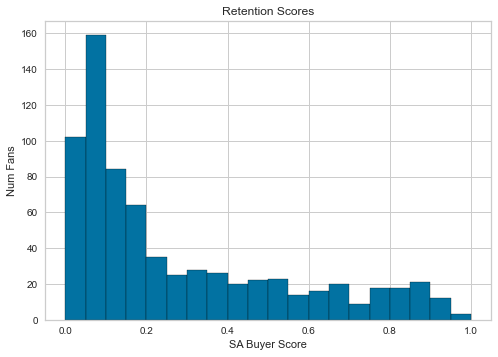

In [9]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [10]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]         3
(0.9, 0.95]        12
(0.85, 0.9]        21
(0.8, 0.85]        18
(0.75, 0.8]        18
(0.7, 0.75]         9
(0.65, 0.7]        20
(0.6, 0.65]        16
(0.55, 0.6]        14
(0.5, 0.55]        23
(0.45, 0.5]        21
(0.4, 0.45]        21
(0.35, 0.4]        26
(0.3, 0.35]        28
(0.25, 0.3]        25
(0.2, 0.25]        35
(0.15, 0.2]        64
(0.1, 0.15]        84
(0.05, 0.1]       159
(-0.001, 0.05]    102
Name: Score_1, dtype: int64

### First we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [11]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

KNPX-VQCS
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Now we can create a session and client to RedShift, and create a new connection using AWS wrangler:

In [12]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = "qa-app",
    database = dbname,
    db_user = "admin"
)

print("CREDENTIALS RETRIEVED SUCCESSFULLY!")

CREDENTIALS RETRIEVED SUCCESSFULLY!


### Before we insert new scores, let's grab a list of the most recent scores (currVersnFlag=1) so we can update them after the new scores are pushed:

In [72]:
sql_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
    WHERE currversnflag = 1
"""

df_recent_scores = wr.data_api.redshift.read_sql_query(
    sql = sql_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_recent_scores.shape[0]}")

TOTAL RECORDS: 719


### Insert the new scores into the customerRetentionScores table:

In [73]:
# create batches of dataframes based on batch size
batch_size = 250
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

In [74]:
print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE:")

fields = f"""
INSERT INTO {dbname}.dw.customerretentionscores (
    attendancePercentage,
    currversnflag,
    dimcustomermasterid,
    insertdate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonYear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(1)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
                {str(lkupclientid)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round(row.Score_1,4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    wr.data_api.redshift.read_sql_query(
        sql = insert_statement, 
        con = conn
    )
    
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 719 NEW RETENTION SCORES TO DATABASE:
 > INSERTED BATCH 1 : ROWS 1 - 250
 > INSERTED BATCH 2 : ROWS 251 - 500
 > INSERTED BATCH 3 : ROWS 501 - 719
RETENTION SCORE INSERTS COMPLETED


### Now let's update the old scores to currVersFlag = 0

In [75]:
print(f"UPDATING {len(df_recent_scores)} OLD RETENTION SCORES IN DATABASE:")

df_recent_scores['currversnflag'] = False
ids = ', '.join(map(str, list(df_recent_scores['customerretentionscoreid'])))

update_statement = f"""
    UPDATE {dbname}.dw.customerretentionscores
    SET currversnflag = 0
    WHERE lkupclientid = {lkupclientid}
    AND customerretentionscoreid IN ({ids})
"""

wr.data_api.redshift.read_sql_query(
    sql = update_statement, 
    con = conn
)

print(f"UPDATED {len(df_recent_scores)} SUCCESSFULLY")

UPDATING 719 OLD RETENTION SCORES IN DATABASE:
UPDATED 719 SUCCESSFULLY


### Let's query RedShift to make sure our records got into the database:

In [76]:
select_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
    AND currversnflag = 1
"""

df_scores = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_scores.shape[0]}")
df_scores.head()

TOTAL RECORDS: 719


,customerretentionscoreid,dimcustomermasterid,lkupclientid,currversnflag,seasonyear,insertdate,sascore,mostrecentattendance,attendancepercentage,tenuredays,product
0,18784,298390369,8,true,2021,2022-03-21 15:22:04,0.0309,2022-03-19 00:00:00,0.500000,5110,Full Season
1,18788,298390605,8,true,2021,2022-03-21 15:22:04,0.2207,2022-03-19 00:00:00,0.250000,5110,Full Season
2,18792,298390818,8,true,2021,2022-03-21 15:22:04,0.3600,2022-03-19 00:00:00,1.000000,5475,Full Season
3,18796,298390965,8,true,2021,2022-03-21 15:22:04,0.2636,2022-03-19 00:00:00,1.000000,1825,Full Season
4,18800,271635830,8,true,2021,2022-03-21 15:22:04,0.2388,2022-03-19 00:00:00,0.333333,5475,Full Season


### We can also use the API to delete records from the database:

In [63]:
delete_statement = f"""
    DELETE 
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

wr.data_api.redshift.read_sql_query(
    sql = delete_statement, 
    con = conn
)

print(f"DELETED ALL RECORDS SUCCESSFULLY")

DELETED ALL RECORDS SUCCESSFULLY
